<a href="https://www.kaggle.com/code/kevinnkansah/spotify-genre-classification-deep-neural-network?scriptVersionId=185990993" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn import set_config

from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


set_config(transform_output='pandas')

2024-06-29 02:12:42.010141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 02:12:42.010268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 02:12:42.155631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Exploratory Data Analysis

In [2]:
df = pd.read_csv('/kaggle/input/spotify-tracks/spotify-tracks.csv')

In [3]:
df.shape

(114000, 21)

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

Naively Dropping duplicates

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.shape

(113550, 20)

Dropping duplicates by ```track_id``` since it will always be a unique value

In [7]:
duplicate_rows = df[df.duplicated('track_id', keep=False)].sort_values(by='track_id', axis=0)
print(f"Number of duplicated rows: {duplicate_rows.shape[0]}")
duplicate_rows.head(10)

Number of duplicated rows: 40108


track_id                       artists  \
15028   001APMDOl3qtx1526T11n1             Pink Sweat$;Kirby   
103211  001APMDOl3qtx1526T11n1             Pink Sweat$;Kirby   
85578   001YQlnDSduXd5LgBd66gT                   Soda Stereo   
100420  001YQlnDSduXd5LgBd66gT                   Soda Stereo   
2106    003vvx7Niy0yvhvHt4a68B                   The Killers   
91801   003vvx7Niy0yvhvHt4a68B                   The Killers   
3257    003vvx7Niy0yvhvHt4a68B                   The Killers   
33178   004h8smbIoAkUNDJvVKwkG                    Ouse;Powfu   
94239   004h8smbIoAkUNDJvVKwkG                    Ouse;Powfu   
97533   006rHBBNLJMpQs8fRC2GDe  Calcinha Preta;Gusttavo Lima   

                             album_name  \
15028                           New RnB   
103211                          New RnB   
85578          Soda Stereo (Remastered)   
100420         Soda Stereo (Remastered)   
2106                           Hot Fuss   
91801                          Hot Fuss   
3257                           Hot Fuss   
33178                      Loners Diary   
94239                      Loners Diary   
97533   CP 25 Anos (Ao Vivo em Aracaju)   

                                      track_name  popularity  duration_ms  \
15028                                     Better           0       176320   
103211                                    Better           0       176320   
85578   El Tiempo Es Dinero - Remasterizado 2007          38       177266   
100420  El Tiempo Es Dinero - Remasterizado 2007          38       177266   
2106                              Mr. Brightside          86       222973   
91801                             Mr. Brightside          86       222973   
3257                              Mr. Brightside          86       222973   
33178                                   Lovemark          58       219482   
94239                                   Lovemark          58       219482   
97533             Agora Estou Sofrendo - Ao Vivo          47       260510   

        explicit  danceability  energy  key  loudness  mode  speechiness  \
15028      False         0.613   0.471    1    -6.644     0       0.1070   
103211     False         0.613   0.471    1    -6.644     0       0.1070   
85578      False         0.554   0.921    2    -4.589     1       0.0758   
100420     False         0.554   0.921    2    -4.589     1       0.0758   
2106       False         0.352   0.911    1    -5.230     1       0.0747   
91801      False         0.352   0.911    1    -5.230     1       0.0747   
3257       False         0.352   0.911    1    -5.230     1       0.0747   
33178       True         0.808   0.331    5   -13.457     1       0.0557   
94239       True         0.808   0.331    5   -13.457     1       0.0557   
97533      False         0.605   0.678    0    -3.257     1       0.0311   

        acousticness  instrumentalness  liveness  valence    tempo  \
15028        0.31600          0.000001    0.1170    0.406  143.064   
103211       0.31600          0.000001    0.1170    0.406  143.064   
85578        0.01940          0.088100    0.3290    0.700  183.571   
100420       0.01940          0.088100    0.3290    0.700  183.571   
2106         0.00121          0.000000    0.0995    0.236  148.033   
91801        0.00121          0.000000    0.0995    0.236  148.033   
3257         0.00121          0.000000    0.0995    0.236  148.033   
33178        0.13100          0.000000    0.2250    0.337  140.035   
94239        0.13100          0.000000    0.2250    0.337  140.035   
97533        0.64200          0.000000    0.1570    0.439  125.059   

        time_signature  track_genre  
15028                4        chill  
103211               4         soul  
85578                1    punk-rock  
100420               1          ska  
2106                 4     alt-rock  
91801                4         rock  
3257                 4  alternative  
33178                4          emo  
94239                4          sad  
97533  

In [8]:
df.drop_duplicates(subset=['track_id'], inplace=True)

In [9]:
df.shape

(89741, 20)

In [10]:
df.dropna(inplace=True)

In [11]:
df.head()

track_id                 artists  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000001    0.3580    0.715   87.917               4    acoustic  
1          0.000006    0.1010    0.267   77.489               4    acoustic  
2          0.000000    0.1170    0.120   76.332               4    acoustic  
3          0.000071    0.1320    0.143  181.740               3    acoustic  
4          0.000000    0.0829    0.167  119.949               4    acoustic

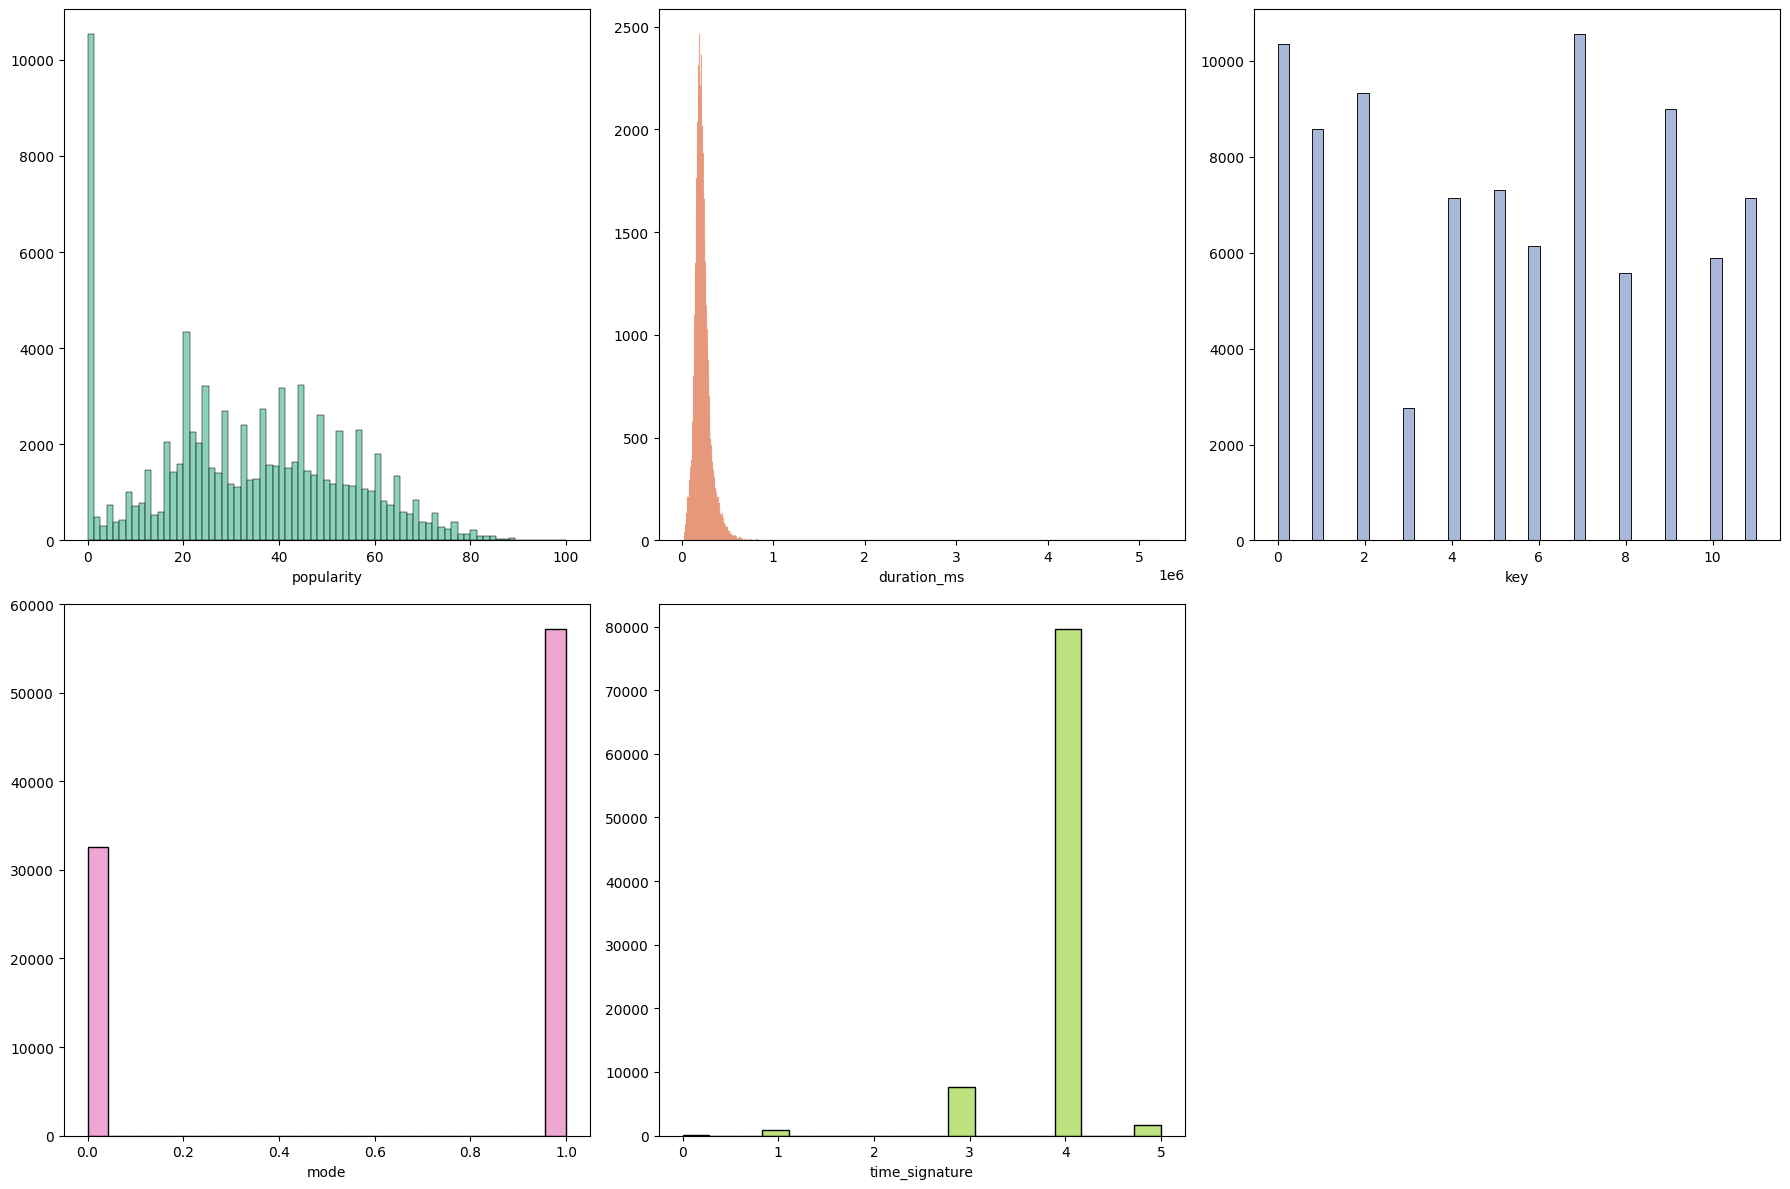

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
ax = ax.flatten()

for idx, (col_name, data) in enumerate(df.select_dtypes('int').items()):
    sns.histplot(data, ax=ax[idx], color=sns.color_palette('Set2')[idx])
    ax[-1].axis('off')
    ax[idx].set_ylabel('')
    
plt.tight_layout()
plt.show()

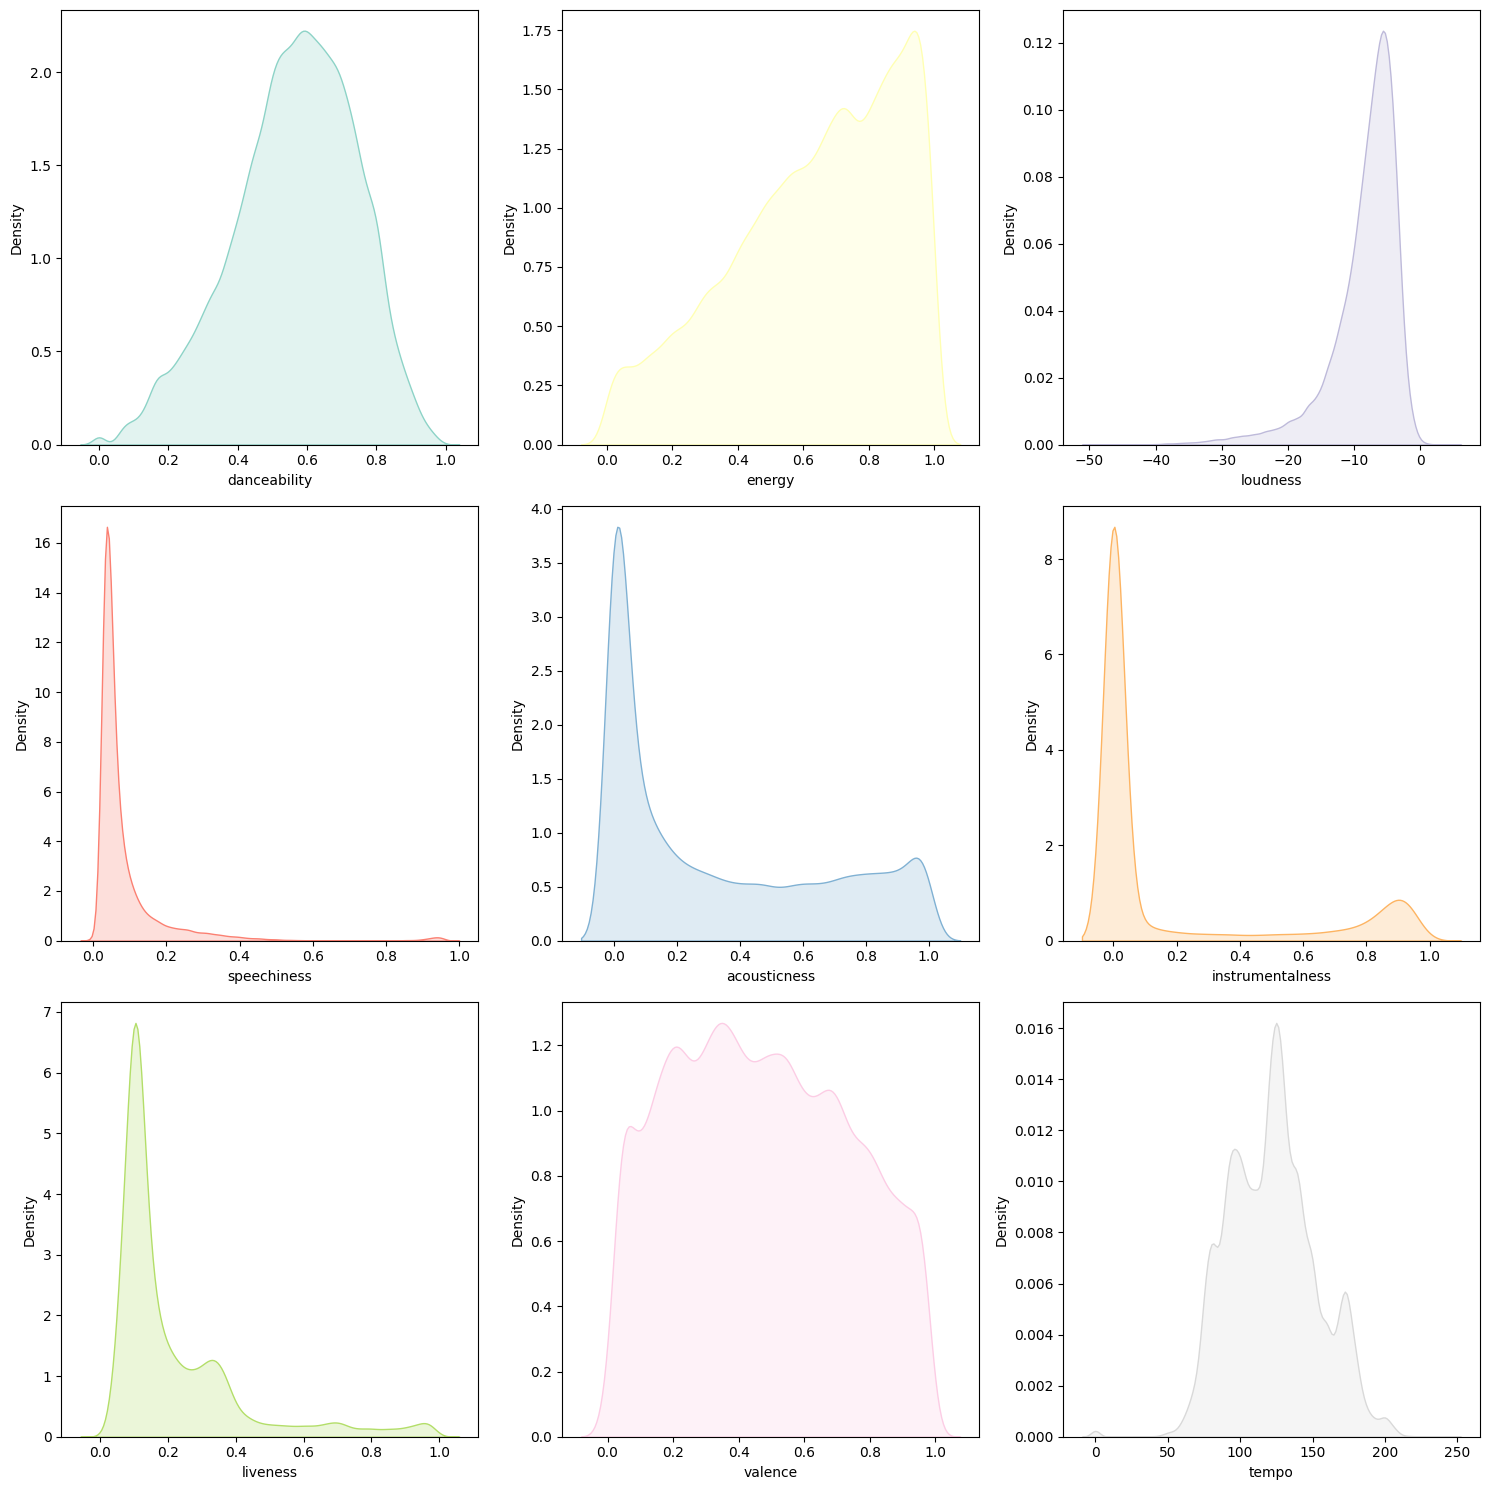

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()

for idx, (col_name, data) in enumerate(df.select_dtypes('float').items()):
    sns.kdeplot(data, ax=ax[idx], color=sns.color_palette('Set3')[idx], fill=True)
    
plt.tight_layout()
plt.show()

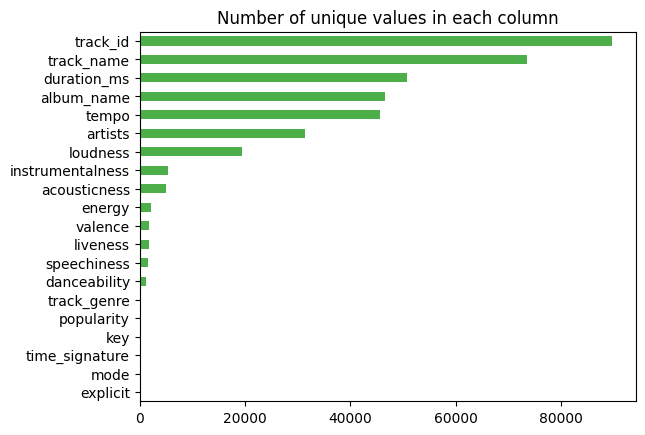

In [14]:

df.nunique().sort_values().plot(kind='barh', color=sns.color_palette('Set1')[2])
plt.title('Number of unique values in each column')
plt.show()

### Data Preprocessing

In [15]:
df = df.drop(['track_id','artists', 'album_name', 'track_name'], axis=1)


In [16]:
scaler = StandardScaler()

In [17]:
scaler =  make_pipeline(MinMaxScaler())
ohe = make_pipeline(OneHotEncoder(sparse_output=False))


In [18]:
preprecessing = make_column_transformer(
    (scaler, ['popularity', 'duration_ms', 'key', 'loudness', 'tempo']), 
    (ohe, ['time_signature']),
    remainder='passthrough' 
)

In [19]:
transformed_df = preprecessing.fit_transform(df)
transformed_df

pipeline-1__popularity  pipeline-1__duration_ms  pipeline-1__key  \
0                         0.73                 0.042473         0.090909   
1                         0.55                 0.026971         0.090909   
2                         0.57                 0.038679         0.000000   
3                         0.71                 0.036978         0.000000   
4                         0.82                 0.036389         0.181818   
...                        ...                      ...              ...   
113995                    0.21                 0.071990         0.454545   
113996                    0.22                 0.071990         0.000000   
113997                    0.22                 0.050276         0.000000   
113998                    0.41                 0.052653         0.636364   
113999                    0.22                 0.044608         0.090909   

        pipeline-1__loudness  pipeline-1__tempo  pipeline-2__time_signature_0  \
0                   0.791392           0.361245                           0.0   
1                   0.597377           0.318397                           0.0   
2                   0.736123           0.313643                           0.0   
3                   0.573701           0.746758                           0.0   
4                   0.737103           0.492863                           0.0   
...                      ...                ...                           ...   
113995              0.612952           0.517705                           0.0   
113996              0.577345           0.350242                           0.0   
113997              0.714648           0.543933                           0.0   
113998              0.714759           0.558651                           0.0   
113999              0.727429           0.325420                           0.0   

        pipeline-2__time_signature_1  pipeline-2__time_signature_3  \
0                                0.0                           0.0   
1                                0.0                           0.0   
2                                0.0                           0.0   
3                                0.0                           1.0   
4                                0.0                           0.0   
...                              ...                           ...   
113995                           0.0                           0.0   
113996                           0.0                           0.0   
113997                           0.0                           0.0   
113998                           0.0                           0.0   
113999                           0.0                           0.0   

        pipeline-2__time_signature_4  pipeline-2__time_signature_5  \
0                                1.0                           0.0   
1                                1.0                           0.0   
2                                1.0                           0.0   
3                                0.0                           0.0   
4                                1.0                           0.0   
...                              ...                           ...   
113995                           0.0                           1.0   
113996                           1.0                           0.0   
113997                           1.0                           0.0   
113998                           1.0                           0.0   
113999                           1.0                           0.0   

        remainder__explicit  remainder__danceability  remainder__energy  \
0                     False                    0.676             0.4610   
1                     False                    0.420             0.1660   
2                     False                    0.438             0.3590   
3                     False                    0.266             0.0596   
4                     False                    0.618             

In [20]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89740 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pipeline-1__popularity        89740 non-null  float64
 1   pipeline-1__duration_ms       89740 non-null  float64
 2   pipeline-1__key               89740 non-null  float64
 3   pipeline-1__loudness          89740 non-null  float64
 4   pipeline-1__tempo             89740 non-null  float64
 5   pipeline-2__time_signature_0  89740 non-null  float64
 6   pipeline-2__time_signature_1  89740 non-null  float64
 7   pipeline-2__time_signature_3  89740 non-null  float64
 8   pipeline-2__time_signature_4  89740 non-null  float64
 9   pipeline-2__time_signature_5  89740 non-null  float64
 10  remainder__explicit           89740 non-null  bool   
 11  remainder__danceability       89740 non-null  float64
 12  remainder__energy             89740 non-null  float64
 13  remai

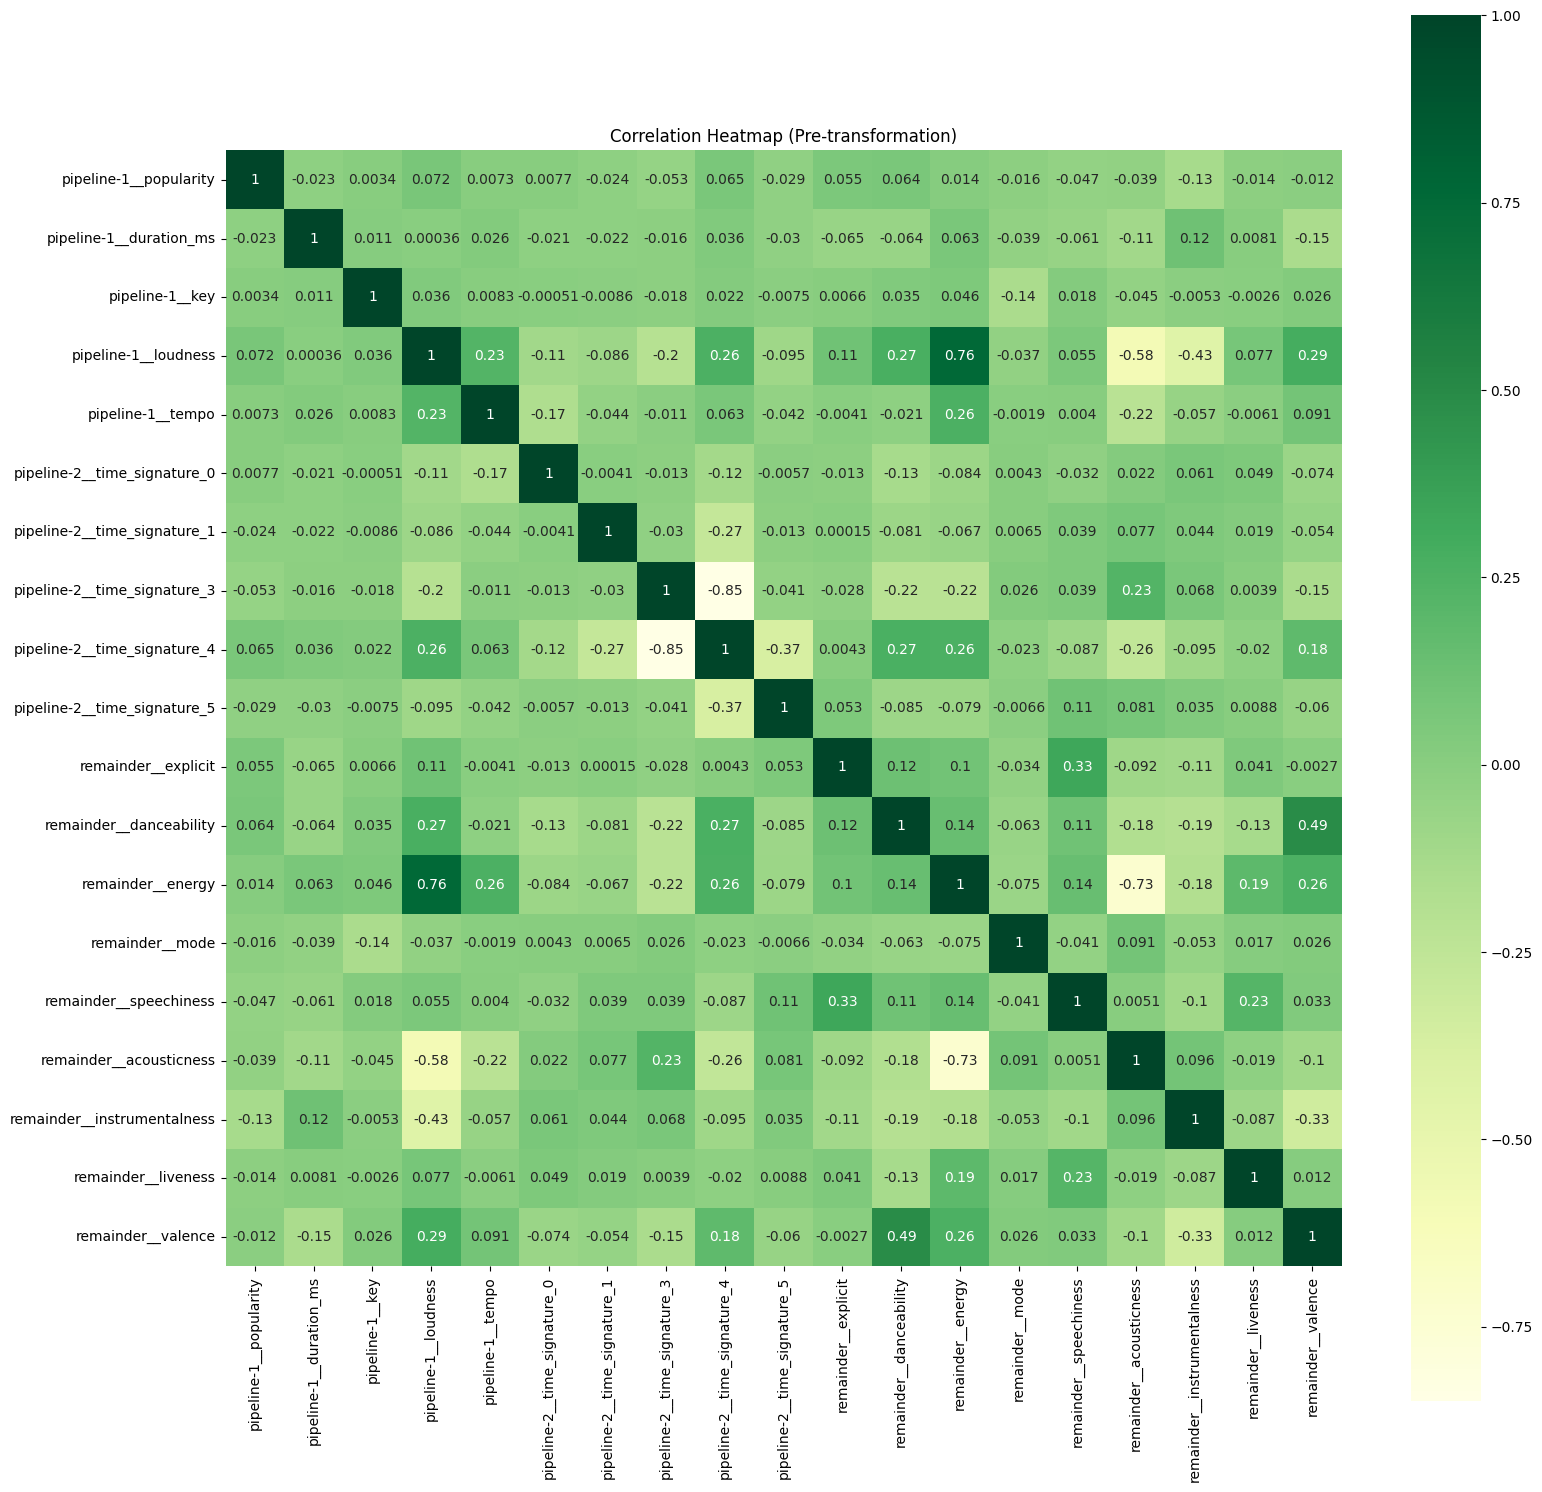

In [21]:
plt.figure(figsize=(18, 18))
sns.heatmap(transformed_df.select_dtypes(['number', 'boolean']).corr(), annot=True, square=True , cmap='YlGn')
plt.title('Correlation Heatmap (Pre-transformation)')
plt.show()

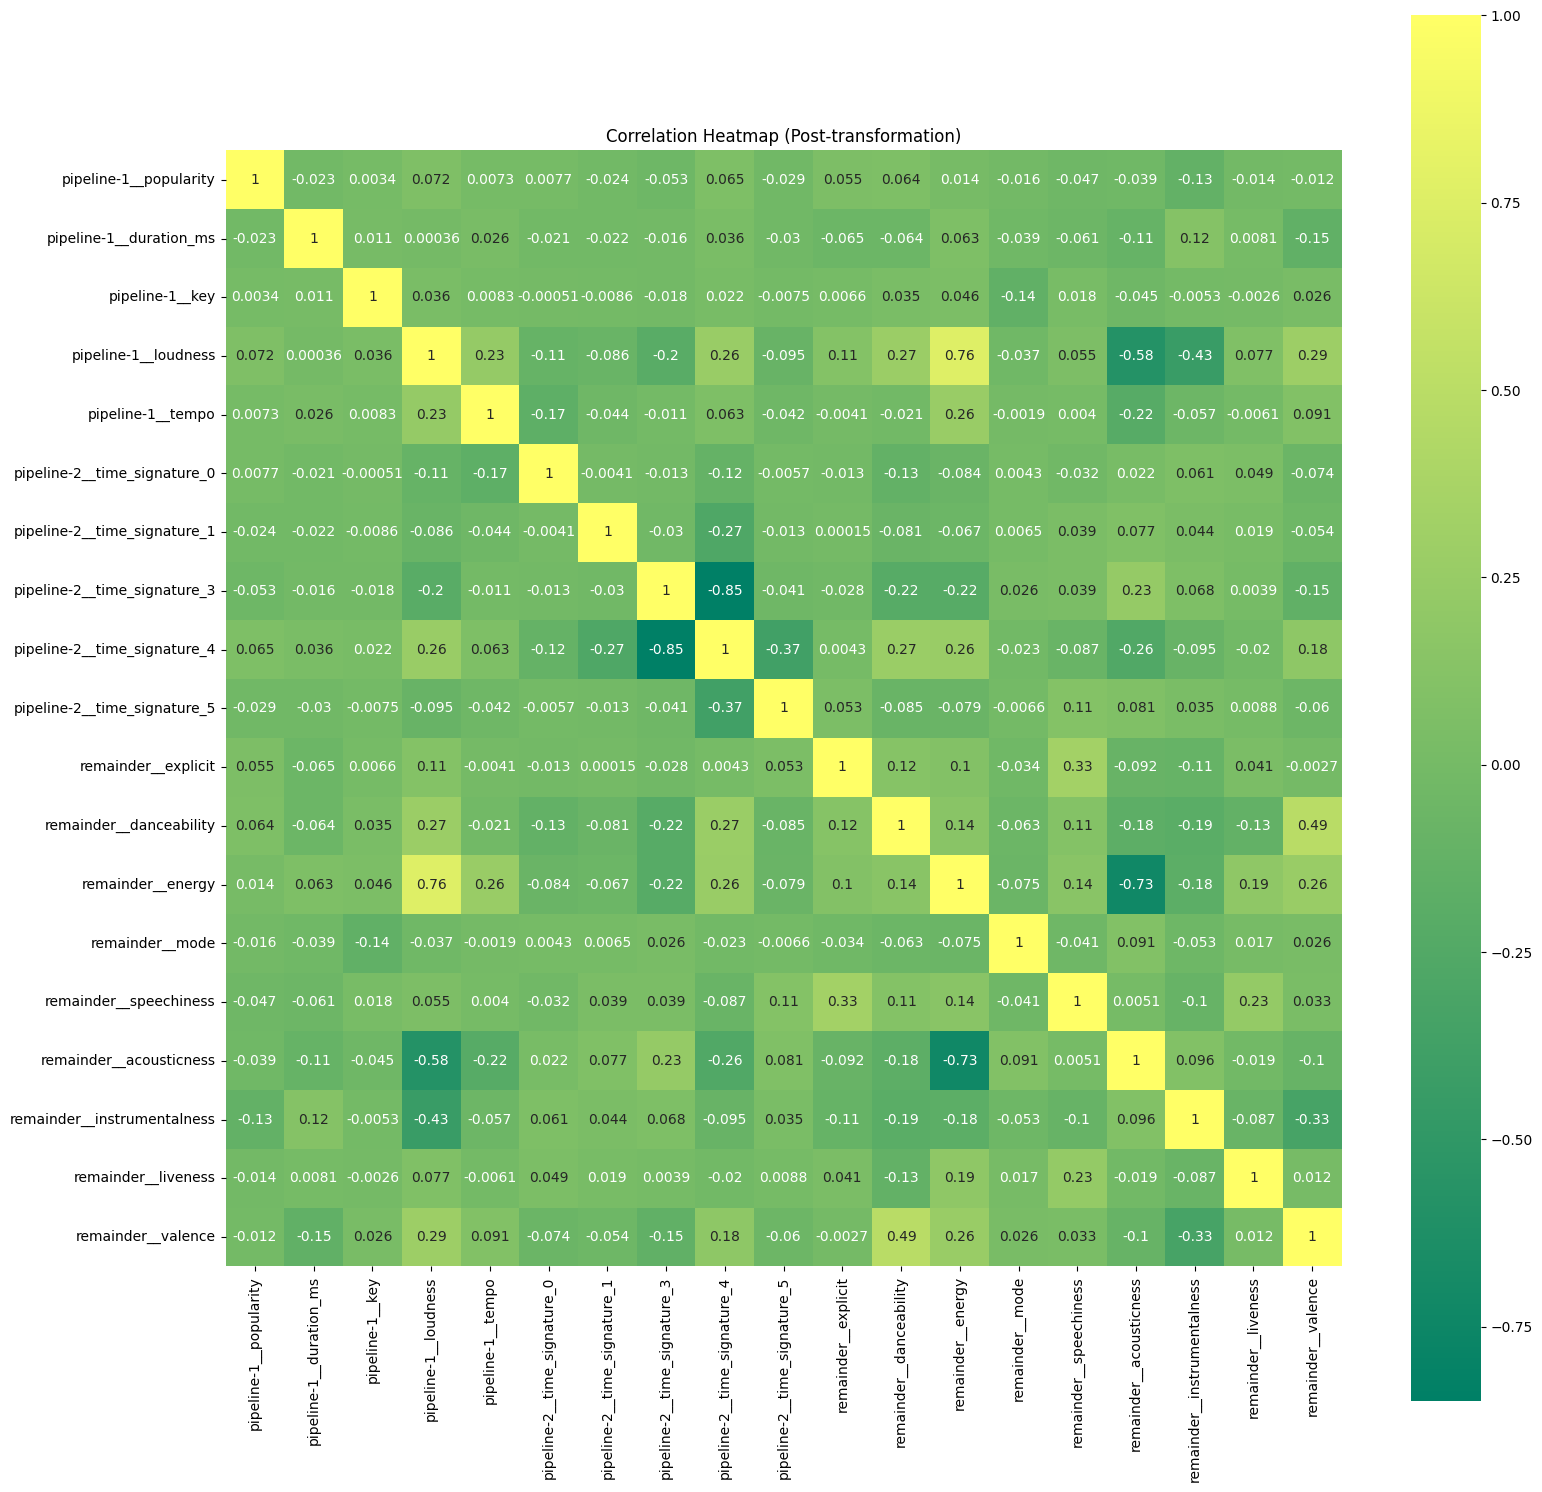

In [22]:
plt.figure(figsize=(18, 18))
sns.heatmap(transformed_df.select_dtypes(['number', 'boolean']).corr(), annot=True, square=True , cmap='summer')
plt.title('Correlation Heatmap (Post-transformation)')
plt.show()

In [23]:
X = transformed_df.drop(['remainder__track_genre'], axis=1)
y = transformed_df['remainder__track_genre']

label_encoder = LabelEncoder()

X = X.to_numpy(dtype='float32')
y = (label_encoder.fit_transform(y))


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=.5, random_state=42)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(62818, 19)
(13461, 19)
(13461, 19)
(62818, 113)
(13461, 113)
(13461,)


In [24]:
num_classes = len(label_encoder.classes_)
num_classes

113

### Data Modelling

In [25]:
inputs = Input(shape=(19,))
x = Dense(128, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 113)            │        14,577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 875,889 (3.34 MB)

 Trainable params: 873,585 (3.33 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [27]:
epochs = 500
early_stopping = EarlyStopping(patience=15)
reduce_lr = ReduceLROnPlateau(patience=5)

history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=epochs, 
                    batch_size=16, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/500
  69/3927 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0198 - loss: 4.9443

I0000 00:00:1719627193.858338      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719627193.878335      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3927/3927 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1219 - loss: 3.7923

W0000 00:00:1719627204.955881      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3927/3927 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.1219 - loss: 3.7922 - val_accuracy: 0.2205 - val_loss: 3.1383 - learning_rate: 0.0010
Epoch 2/500
3927/3927 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2039 - loss: 3.1908 - val_accuracy: 0.2599 - val_loss: 2.9297 - learning_rate: 0.0010
Epoch 3/500
3927/3927 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2501 - loss: 2.9562 - val_accuracy: 0.2862 - val_loss: 2.7645 - learning_rate: 0.0010
Epoch 4/500
3927/3927 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.2657 - loss: 2.8473 - val_accuracy: 0.2714 - val_loss: 2.8265 - learning_rate: 0.0010
Epoch 5/500
3927/3927 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2885 - loss: 2.7669 - val_accuracy: 0.3108 - val_loss: 2.6798 - learning_rate: 0.0010
Epoch 6/500
3927/3927 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2899 - loss: 2.7348 - val_accuracy: 0.3194 - val_loss: 2.5970 - learning_rate: 0.0010
Epoch 7/500
3927/3927 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.3035 -

### Model Evaluation

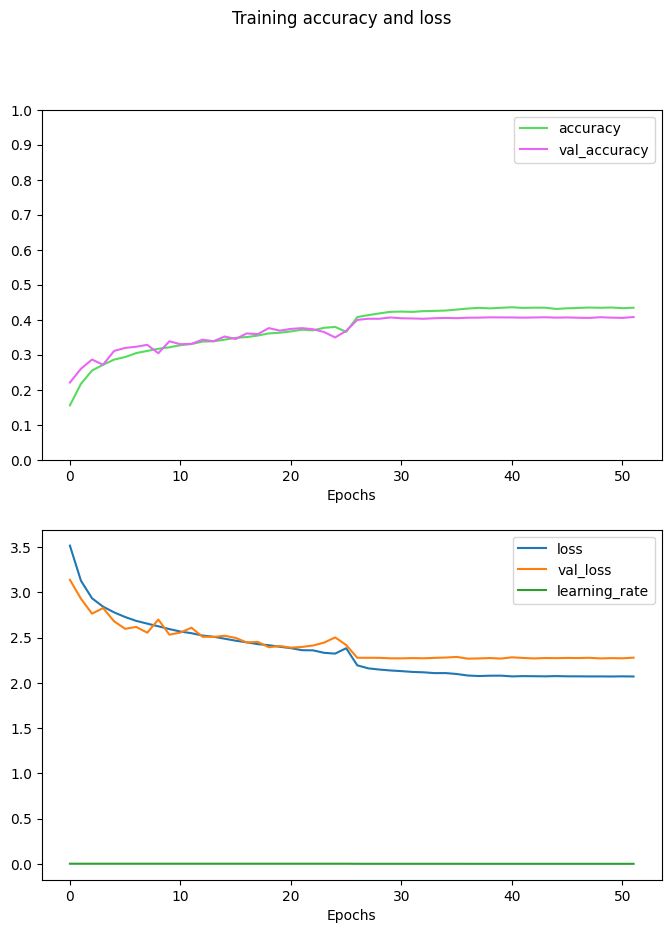

In [28]:
metrics = history.history

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))
plt.suptitle("Training accuracy and loss")
for lable, values in metrics.items():
    if lable == "accuracy":
        ax[0].plot(values, label=lable, color=sns.color_palette("hls")[2])
    elif lable == "val_accuracy":
        ax[0].plot(values, label=lable, color=sns.color_palette("husl")[5])
    else:
        ax[1].plot(values, label=lable)

ax[0].set_xlabel("Epochs")
ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0].legend()

ax[1].set_xlabel("Epochs")
ax[1].legend()
plt.show()

In [29]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [30]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.27      0.24      0.26       164
           1       0.44      0.33      0.37       155
           2       0.21      0.29      0.24       150
           3       0.33      0.19      0.24        64
           4       0.41      0.34      0.37       141
           5       0.23      0.27      0.25       136
           6       0.54      0.60      0.57       129
           7       0.43      0.48      0.46       157
           8       0.29      0.24      0.26       134
           9       0.32      0.33      0.33       143
          10       0.50      0.54      0.52       149
          11       0.18      0.09      0.12       136
          12       0.33      0.39      0.36       147
          13       0.53      0.46      0.50       151
          14       0.42      0.57      0.48       152
          15       0.27      0.34      0.30       133
          16       0.57      0.67      0.62       128
          17       0.41    

In [31]:
fig, ax = plt.subplots(figsize=(30, 30), dpi=300)
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Greens', colorbar=False, display_labels=label_encoder.classes_, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

So did I do bad ??? Lets find out with the infamous ```XGBoost``` as a baseline model

In [32]:
X = transformed_df.drop(['remainder__track_genre'], axis=1)
y = transformed_df['remainder__track_genre']

y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [34]:
y_pred_xgb = xgb.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.26      0.26      0.26       202
           1       0.34      0.35      0.34       194
           2       0.35      0.47      0.40       195
           3       0.74      0.47      0.58       104
           4       0.35      0.36      0.36       175
           5       0.30      0.34      0.32       173
           6       0.59      0.58      0.58       201
           7       0.43      0.43      0.43       217
           8       0.34      0.27      0.30       174
           9       0.27      0.32      0.29       209
          10       0.44      0.47      0.45       202
          11       0.22      0.16      0.18       166
          12       0.31      0.30      0.31       205
          13       0.58      0.52      0.55       211
          14       0.41      0.43      0.42       182
          15       0.33      0.42      0.37       195
          16       0.66      0.69      0.67       159
          17       0.29    

In [36]:
fig, ax = plt.subplots(figsize=(30, 30), dpi=300)
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap='YlGn', colorbar=False, display_labels=label_encoder.classes_, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Conclusion

It seems that in this task high accuracy may be difficult to achieve, this due to there being many genres( target labels ), maybe it would be best to group similar genres to reduce the  number of target classes which is over ***100***. That companied with improved model architecture or a hyperparameter tuned ```XGBoost``` model would greatly increase accuracy.